In [1]:
from utils.models import *

In [2]:
env()

--------- Dependencies ---------
python: 3.8.10 | packaged by conda-forge | (default, May 11 2021, 06:25:23) [MSC v.1916 64 bit (AMD64)]
numpy: 1.21.0
pandas: 1.2.4
matplotlib: 3.4.2
scipy: 1.7.1
statsmodels: 0.13.0


## VIX

In [3]:
wti = load('data/WTI.csv').pct_change().dropna()
c1 = clean_series('contract_1', wti)
vix = load('data/VIX.csv')
vix_shock = calc_shock('VIX', vix)

In [4]:
window = 36 # number of months for measurement sample (lags mean only 24 datapoints available for each sample)
conf_int = .1 # confidence interval (2-tailed, Student's t)
kalman = KF(window=window, conf_int=conf_int)
kf, confs = kalman.run('contract_1', 'VIX', c1.join(vix_shock).dropna())

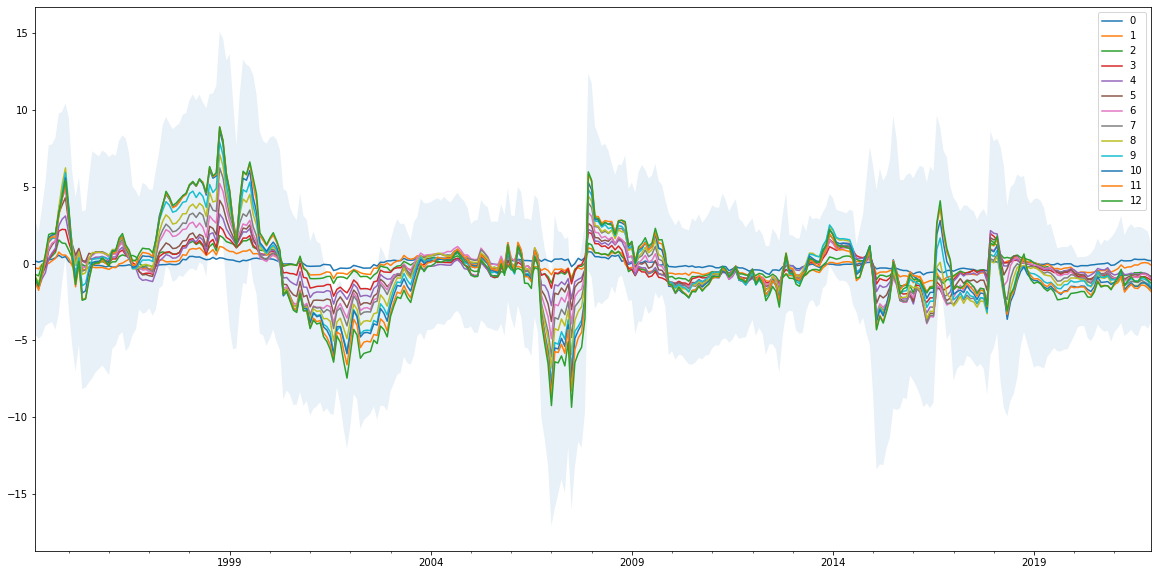

In [5]:
kf.plot(figsize=(20,10))
plt.fill_between(confs.index, confs['lower'], confs['upper'], alpha=0.1)

In [6]:
confs[confs['lower'] > 0] # significant upward movements

,lower,upper
1994-12-01,0.411318,10.414942
1998-04-01,0.053784,10.976656
1998-07-01,1.587255,11.022874
1998-08-01,0.335822,11.051733
1998-09-01,0.246093,11.554178
1998-10-01,2.708867,15.061295
1998-11-01,1.321721,14.643962
1999-07-01,0.424142,12.779682


In [7]:
confs[confs['upper'] < 0] # significant downward movements

,lower,upper
2001-06-01,-9.414977,-0.738521
2001-07-01,-9.757936,-1.416918
2001-08-01,-9.844962,-2.983748
2001-09-01,-8.022916,-1.401057
2001-10-01,-9.153961,-1.096297
2001-11-01,-10.742972,-1.971418
2001-12-01,-12.019895,-2.883939
2002-01-01,-10.621948,-1.136405
2002-02-01,-8.493994,-0.060783
2002-03-01,-8.813433,-0.503401


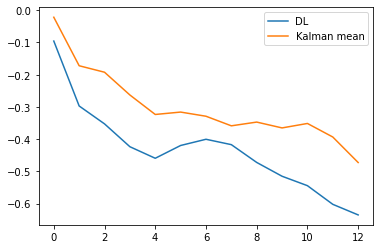

In [8]:
dl = DL('contract_1', 'VIX', c1.join(vix_shock).dropna().iloc[window-12:])
plt.plot(np.cumsum(dl.model.params[1:]), label='DL')
plt.plot(kf.mean(), label='Kalman mean')
plt.legend()

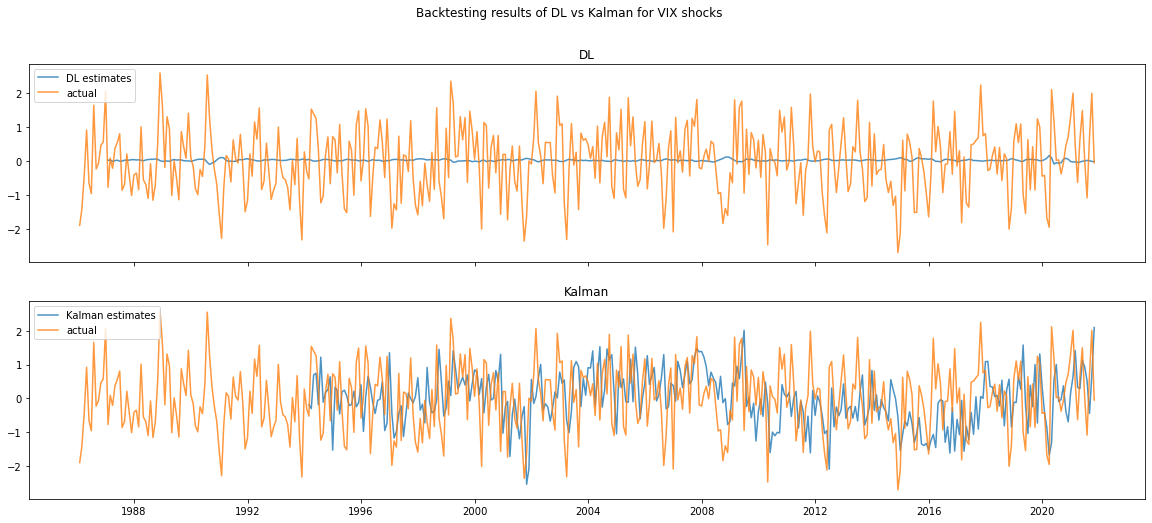

In [9]:
kalman_backtest = kalman.backtest()

x = wti.contract_1
dl_backtest = dl.model.params[0] + x * dl.model.params[1]
for i in range(2, 14): # remember params contain constant at [0]
    dl_backtest += x.shift(i-1) * dl.model.params[i]

fig, ax = plt.subplots(2, sharex=True, figsize=(20,8))
fig.suptitle('Backtesting results of DL vs Kalman for VIX shocks')
ax[0].plot(dl_backtest, label='DL estimates', alpha=0.8)
ax[0].plot(c1.contract_1, label='actual', alpha=0.8)
ax[0].set_title('DL')
ax[0].legend()
ax[1].plot(kalman_backtest, label='Kalman estimates', alpha=0.8)
ax[1].plot(c1.contract_1, label='actual', alpha=0.8)
ax[1].set_title('Kalman')
ax[1].legend()

In [10]:
rmse_dl = np.sqrt(np.sum((x.loc[min(dl_backtest.index):] - dl_backtest) ** 2) / len(dl_backtest))
rmse_kalman = np.sqrt(np.sum((x.loc[min(kalman_backtest.index):] - kalman_backtest) ** 2) / len(kalman_backtest))
print(f'RMSE DL: {rmse_dl}')
print(f'RMSE Kalman: {rmse_kalman}')

RMSE DL: 0.11110127865062254
RMSE Kalman: 0.7709268017911626


## GPR

In [11]:
gpr = load('data/GPRGlobal.csv')
gpr_shock = calc_shock('GPRI', gpr)

In [12]:
kf2, confs2 = kalman.run('contract_1', 'GPRI', c1.join(gpr_shock).dropna())

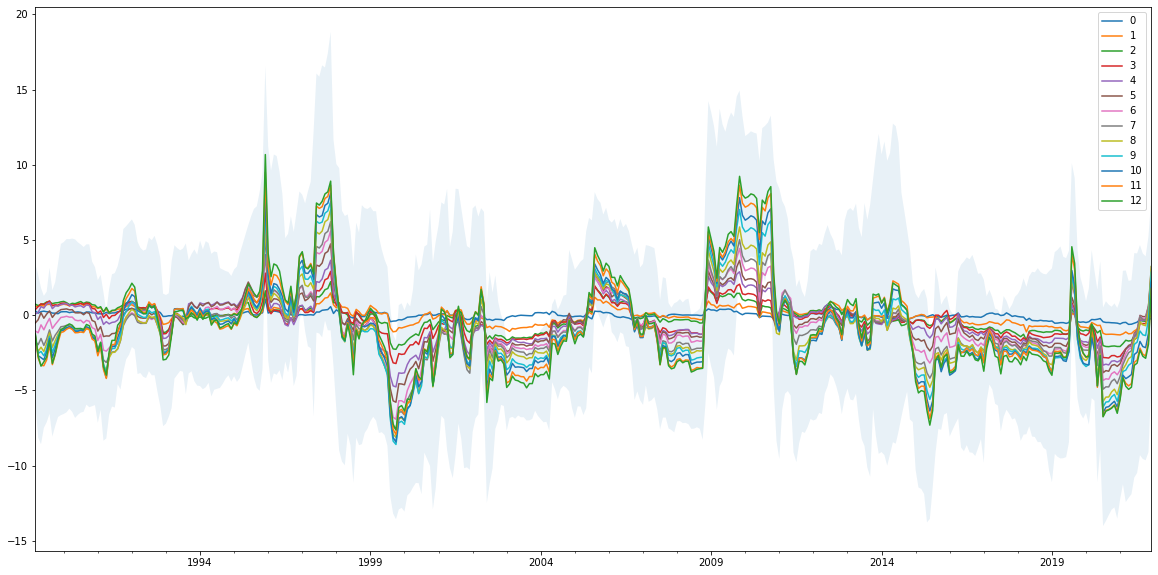

In [13]:
kf2.plot(figsize=(20, 10))
plt.fill_between(confs2.index, confs2['lower'], confs2['upper'], alpha=0.1)

In [14]:
confs2[confs2['lower'] > 0]

,lower,upper
1995-12-01,4.793346,16.568664
1997-01-01,0.440264,8.006113
2005-08-01,0.794466,8.180956
2005-09-01,0.232260,7.719268
2006-01-01,0.143776,6.347379
2009-10-01,0.204121,14.534195
2009-11-01,3.535510,14.932677
2009-12-01,2.787147,13.251650
2010-01-01,3.664811,11.906917
2010-02-01,3.702549,12.053695


In [15]:
confs2[confs2['upper'] < 0]

,lower,upper
1999-09-01,-13.189488,-1.289114
1999-10-01,-13.562167,-1.698801
2002-12-01,-6.032884,-0.455776
2003-01-01,-7.669246,-1.937466
2003-02-01,-6.837281,-2.291336
2003-03-01,-6.752463,-1.343481
2003-04-01,-6.883488,-1.735194
2003-05-01,-6.664447,-2.054714
2003-06-01,-6.782145,-2.165146
2003-07-01,-6.782209,-2.246084


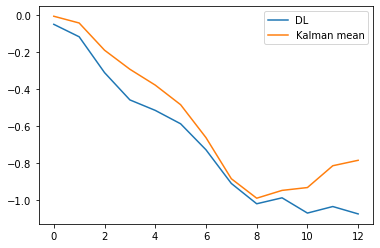

In [16]:
dl2 = DL('contract_1', 'GPRI', c1.join(gpr_shock).dropna().iloc[window:])
plt.plot(np.cumsum(dl2.model.params[1:]), label='DL')
plt.plot(kf2.mean(), label='Kalman mean')
plt.legend()

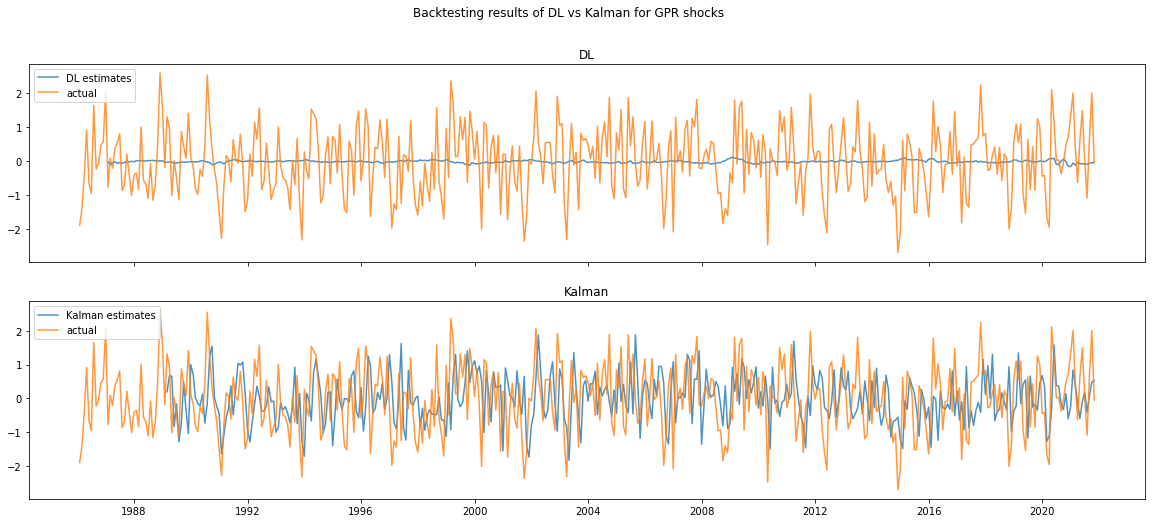

In [17]:
kalman_backtest2 = kalman.backtest()

dl_backtest2 = dl2.model.params[0] + x * dl2.model.params[1]
for i in range(2, 14): # remember params contain constant at [0]
    dl_backtest2 += x.shift(i-1) * dl2.model.params[i]

fig, ax = plt.subplots(2, sharex=True, figsize=(20,8))
fig.suptitle('Backtesting results of DL vs Kalman for GPR shocks')
ax[0].plot(dl_backtest2, label='DL estimates', alpha=0.8)
ax[0].plot(c1.contract_1, label='actual', alpha=0.8)
ax[0].set_title('DL')
ax[0].legend()
ax[1].plot(kalman_backtest2, label='Kalman estimates', alpha=0.8)
ax[1].plot(c1.contract_1, label='actual', alpha=0.8)
ax[1].set_title('Kalman')
ax[1].legend()

In [18]:
rmse_dl2 = np.sqrt(np.sum((x.loc[min(dl_backtest2.index):] - dl_backtest2) ** 2) / len(dl_backtest2))
rmse_kalman2 = np.sqrt(np.sum((x.loc[min(kalman_backtest2.index):] - kalman_backtest2) ** 2) / len(kalman_backtest2))
print(f'RMSE DL: {rmse_dl2}')
print(f'RMSE Kalman: {rmse_kalman2}')

RMSE DL: 0.1044121335776065
RMSE Kalman: 0.6943812147088883
